Columns in the dataset: Index(['#Passengers'], dtype='object')
Columns after cleaning: Index(['#Passengers'], dtype='object')
Column not found: 'Passengers'. Please use the correct column name.
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
Epoch 1/20
5/5 [==============================] - 1s 70ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0067
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0066
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 7/20
5/5 [==============================] - 0s 16m

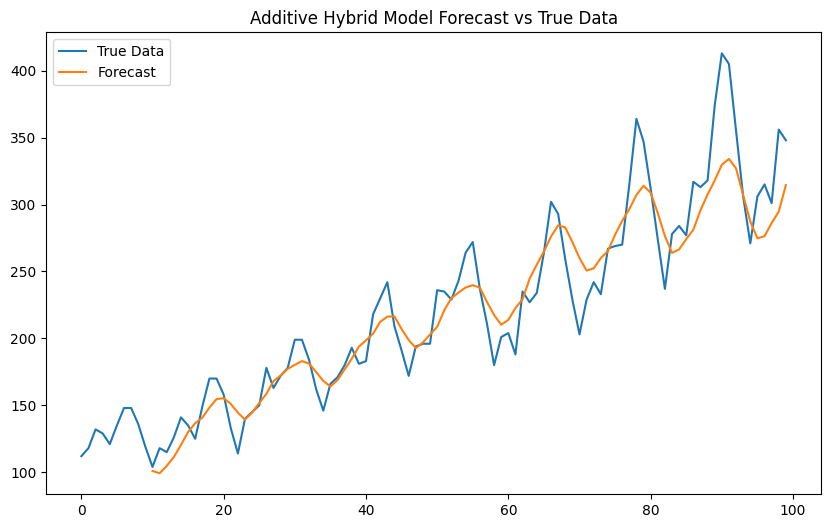

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

data = pd.read_csv('Passengers.csv', index_col='Month', parse_dates=True)

print("Columns in the dataset:", data.columns)

data.columns = data.columns.str.strip()

print("Columns after cleaning:", data.columns)

try:
    data = data['Passengers'].values.reshape(-1, 1)
except KeyError as e:
    print(f"Column not found: {e}. Please use the correct column name.")
    print(data.head())

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.15)
train, val, test = np.split(data_scaled, [train_size, train_size + val_size])

X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train
linear_model = LinearRegression().fit(X_train, y_train)
linear_forecast_train = linear_model.predict(X_train)

residuals_train = y_train - linear_forecast_train

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X_lstm_train, y_lstm_train = create_sequences(residuals_train, seq_length)

model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16, validation_split=0.2)

linear_forecast_truncated = linear_forecast_train[seq_length:].flatten()

lstm_forecast = model_lstm.predict(X_lstm_train).flatten()

final_forecast = linear_forecast_truncated + lstm_forecast

final_forecast_original_scale = scaler.inverse_transform(final_forecast.reshape(-1, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(train)), scaler.inverse_transform(train), label='True Data')
plt.plot(np.arange(seq_length, seq_length + len(final_forecast_original_scale)), final_forecast_original_scale, label='Forecast')
plt.title('Additive Hybrid Model Forecast vs True Data')
plt.legend()
plt.show()


Epoch 1/20
6/6 [==============================] - 0s 4ms/step - loss: 6.3207
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 2.0329
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 1.4131
Epoch 4/20
6/6 [==============================] - 0s 3ms/step - loss: 1.0795
Epoch 5/20
6/6 [==============================] - 0s 3ms/step - loss: 0.8217
Epoch 6/20
6/6 [==============================] - 0s 3ms/step - loss: 0.5952
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.3989
Epoch 8/20
6/6 [==============================] - 0s 3ms/step - loss: 0.2858
Epoch 9/20
6/6 [==============================] - 0s 3ms/step - loss: 0.2221
Epoch 10/20
6/6 [==============================] - 0s 3ms/step - loss: 0.1587
Epoch 11/20
6/6 [==============================] - 0s 3ms/step - loss: 0.1207
Epoch 12/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0964
Epoch 13/20
6/6 [==============================] - 0s 3ms/step - loss: 0.

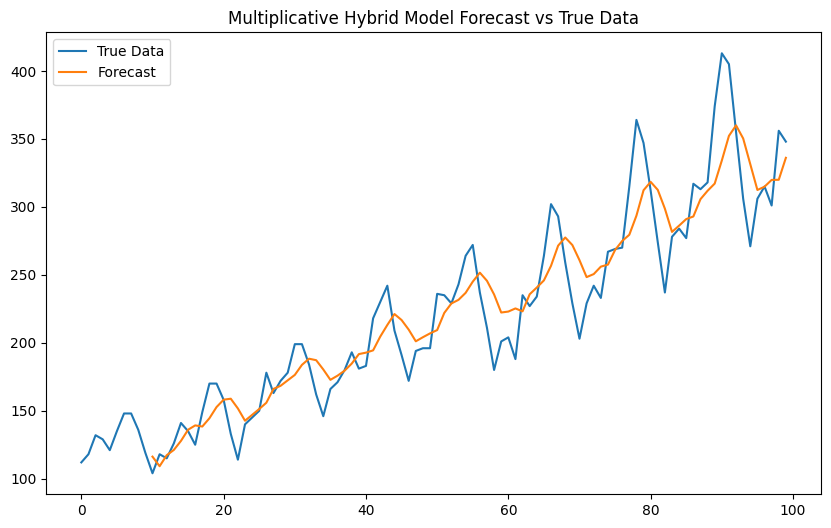

In [6]:
linear_forecast_train = linear_model.predict(X_train)

residuals_train = y_train / (linear_forecast_train + 1e-8)

X_lstm_train, y_lstm_train = create_sequences(residuals_train, seq_length)
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16)

lstm_forecast = model_lstm.predict(X_lstm_train)

linear_forecast_truncated = linear_forecast_train[seq_length:]

final_forecast = linear_forecast_truncated.flatten() * lstm_forecast.flatten()

final_forecast_original_scale = scaler.inverse_transform(final_forecast.reshape(-1, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(train)), scaler.inverse_transform(train), label='True Data')
plt.plot(np.arange(seq_length, seq_length + len(final_forecast_original_scale)), final_forecast_original_scale, label='Forecast')
plt.title('Multiplicative Hybrid Model Forecast vs True Data')
plt.legend()
plt.show()


Epoch 1/20
9/9 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 3/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 6/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 8/20
9/9 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 9/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 10/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 11/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 12/20
9/9 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 13/20
9/9 [==============================] - 0s 6ms/step - loss: 0.

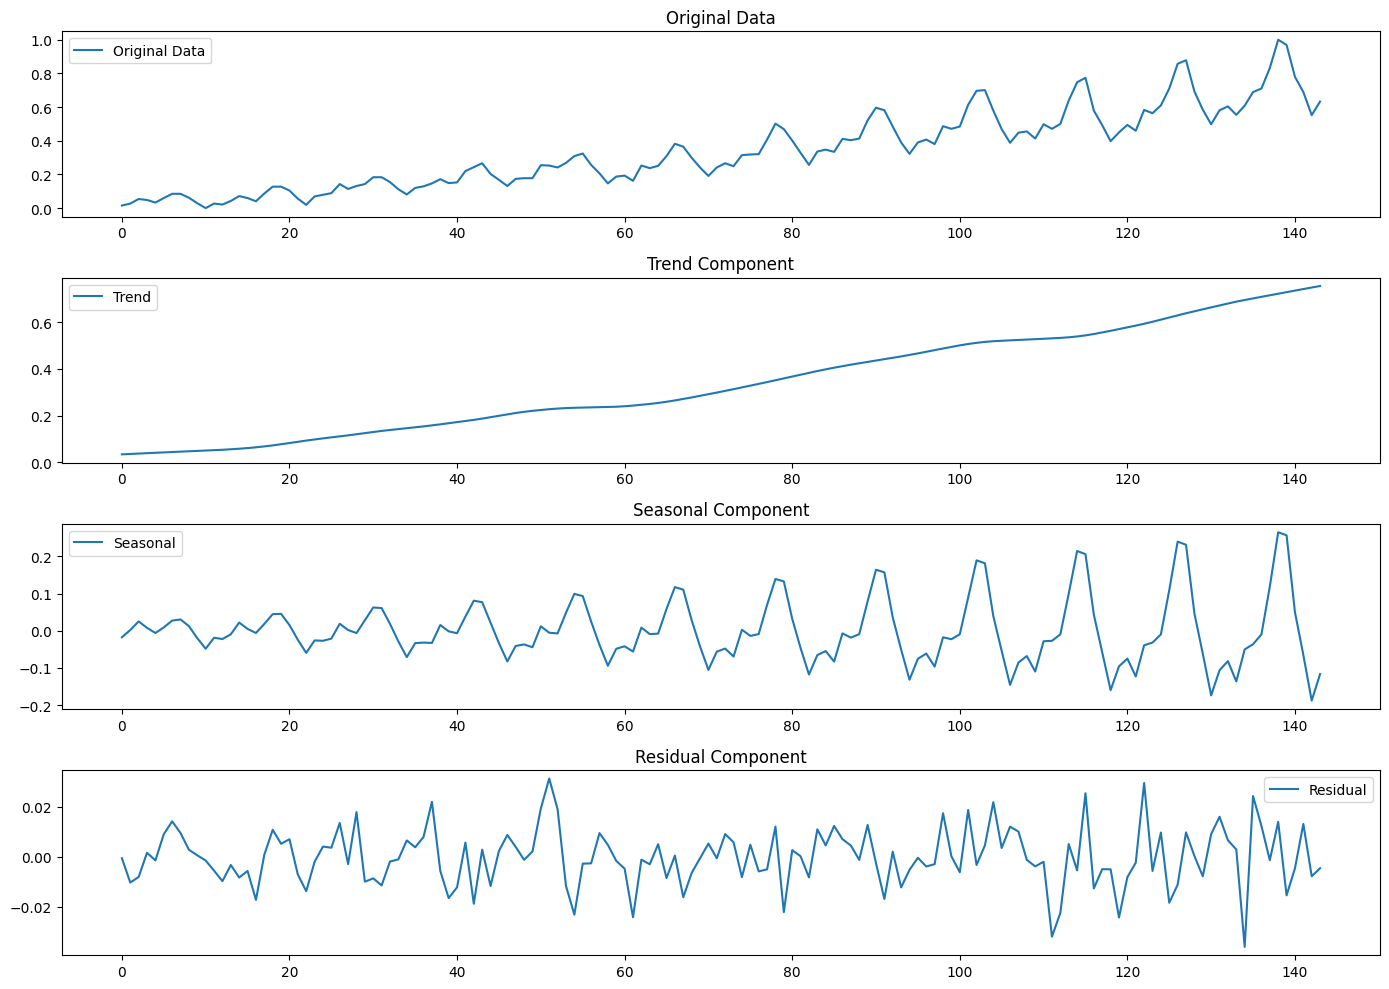

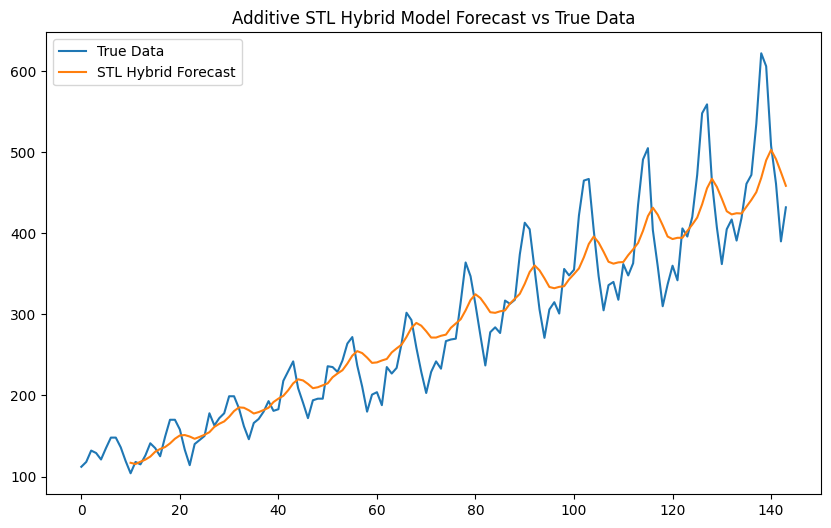

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import tensorflow as tf

data_scaled_flatten = data_scaled.flatten()

stl = STL(data_scaled_flatten, seasonal=13, period=12)
result = stl.fit()
seasonal, trend, residual = result.seasonal, result.trend, result.resid

X_trend = np.arange(len(trend)).reshape(-1, 1)
linear_model_trend = LinearRegression().fit(X_trend, trend)
trend_forecast = linear_model_trend.predict(X_trend)

X_seasonal, y_seasonal = create_sequences(seasonal.reshape(-1, 1), seq_length)
model_lstm.fit(X_seasonal, y_seasonal, epochs=20, batch_size=16)
seasonal_forecast = model_lstm.predict(X_seasonal)

X_residual, y_residual = create_sequences(residual.reshape(-1, 1), seq_length)
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(50, activation='relu', input_shape=(X_residual.shape[1], X_residual.shape[2])),
    tf.keras.layers.Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_residual, y_residual, epochs=20, batch_size=16)
residual_forecast = model_gru.predict(X_residual)

seasonal_forecast_truncated = seasonal_forecast.flatten()
residual_forecast_truncated = residual_forecast.flatten()
trend_forecast_truncated = trend_forecast[seq_length:].flatten()

final_forecast_stl_add = trend_forecast_truncated + seasonal_forecast_truncated + residual_forecast_truncated

final_forecast_original_scale = scaler.inverse_transform(final_forecast_stl_add.reshape(-1, 1))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(data_scaled[seq_length:], final_forecast_stl_add)
print(f'Mean Squared Error: {mse}')


plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(data_scaled, label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

data_scaled_reshaped = data_scaled.reshape(-1, 1)

plt.plot(np.arange(len(data_scaled)), scaler.inverse_transform(data_scaled_reshaped), label='True Data')

plt.plot(np.arange(seq_length, seq_length + len(final_forecast_original_scale)), final_forecast_original_scale, label='STL Hybrid Forecast')

plt.title('Additive STL Hybrid Model Forecast vs True Data')
plt.legend()
plt.show()


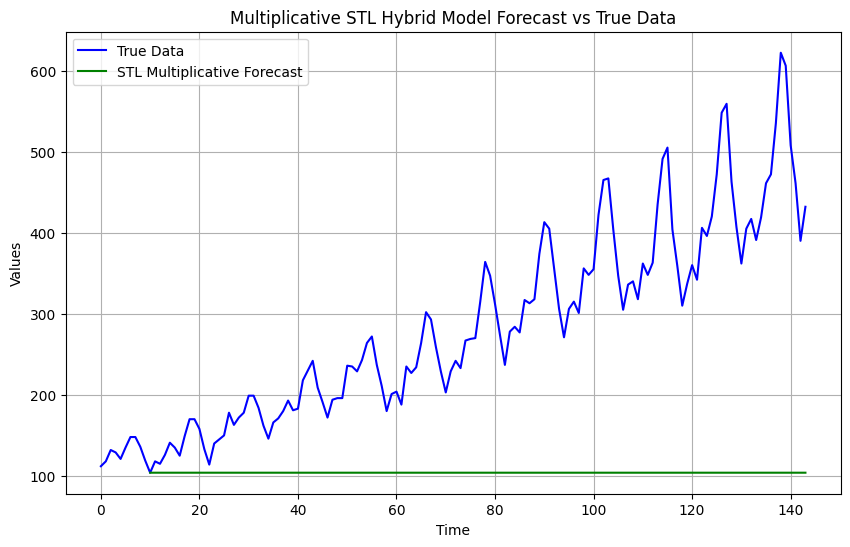

In [14]:
min_len = min(len(trend_forecast), len(seasonal_forecast_truncated), len(residual_forecast_truncated))

trend_forecast_truncated = trend_forecast[:min_len].flatten()
seasonal_forecast_truncated = seasonal_forecast_truncated[:min_len]
residual_forecast_truncated = residual_forecast_truncated[:min_len]

final_forecast_stl_mult = trend_forecast_truncated * seasonal_forecast_truncated * residual_forecast_truncated

final_forecast_original_scale_mult = scaler.inverse_transform(final_forecast_stl_mult.reshape(-1, 1))

plt.figure(figsize=(10, 6))

data_scaled_reshaped = data_scaled.reshape(-1, 1)

plt.plot(np.arange(len(data_scaled)), scaler.inverse_transform(data_scaled_reshaped), label='True Data', color='blue')

plt.plot(np.arange(seq_length, seq_length + len(final_forecast_original_scale_mult)), 
         final_forecast_original_scale_mult, label='STL Multiplicative Forecast', color='green')

plt.title('Multiplicative STL Hybrid Model Forecast vs True Data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
